# Boundary Conditions

In [ ]:
# Import Libraries
%run /Users/u4eeevmq/Documents/Python/HyporheicFloPy/VQuintana/common_imports.py

# Retrieve stored variables
%store -r md6_exe_path
%store -r md7_exe_path
%store -r sim_name
%store -r workspace
%store -r figs_path
%store -r gwf_name
%store -r prt_name
%store -r mp7_name
%store -r gwf_ws
%store -r prt_ws
%store -r mp7_ws
%store -r headfile
%store -r head_filerecord
%store -r headfile_prt
%store -r budgetfile
%store -r budget_filerecord
%store -r budgetfile_prt
%store -r budget_filerecord_prt
%store -r trackfile_prt
%store -r trackhdrfile_prt
%store -r trackcsvfile_prt
%store -r write
%store -r run
%store -r plot
%store -r plot_show
%store -r plot_save

# Retrieve model parameters
%store -r length_units
%store -r time_units
%store -r nper
%store -r cell_size_x
%store -r cell_size_y
%store -r gw_mod_depth
%store -r z
%store -r kh
%store -r kv
%store -r gw_offset
%store -r porosity
%store -r rch_iface
%store -r rch_iflowface
%store -r recharge_rate
%store -r nstp
%store -r perlen
%store -r tsmult

# Retrieve spatial data
%store -r hec_ras_crs
%store -r terrain_elevation
%store -r raster_transform
%store -r transform
%store -r raster_crs
%store -r output_raster
%store -r cropped_output_raster
%store -r ground_water_domain
%store -r left_boundary
%store -r right_boundary

# retrieve model domain data
%store -r terrain_elevation
%store -r raster_transform
%store -r raster_crs
%store -r raster_bounds_box
%store -r bed_elevation
%store -r raster_width
%store -r raster_height
%store -r ncol
%store -r nrow
%store -r top
%store -r nlay
%store -r grid_x
%store -r grid_y
%store -r grid_points
%store -r intersecting_points
%store -r xorigin
%store -r yorigin
%store -r xmin
%store -r ymin
%store -r xmax
%store -r ymax
%store -r tops
%store -r botm

# retrieve model boundary data
%store -r left_start
%store -r left_end
%store -r right_start
%store -r right_end
%store -r upstream_start_x
%store -r upstream_start_y
%store -r upstream_end_x
%store -r upstream_end_y
%store -r downstream_start_x
%store -r downstream_start_y
%store -r downstream_end_x
%store -r downstream_end_y
%store -r upstream_line
%store -r downstream_line
%store -r upstream_boundary
%store -r downstream_boundary
%store -r grid_cells
%store -r grid_gdf
%store -r idomain

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
#---------------------------Identify Boundary Cells-----------------------------#
## Perform a spatial analysis to identify boundary cells 
grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
grid_gdf["intersect_downstream_boundary"] = grid_gdf.geometry.intersects(downstream_boundary.unary_union)

## Function to locate boundary cells
def identify_boundary_cells(idomain):
    boundary_cells = set()
    nlay, nrow, ncol = idomain.shape

    for row in range(nrow):
        for col in range(ncol):
            if idomain[0, row, col] == 1:
                if (
                    row > 0 and idomain[0, row - 1, col] == 0 or
                    row < nrow - 1 and idomain[0, row + 1, col] == 0 or
                    col > 0 and idomain[0, row, col - 1] == 0 or
                    col < ncol - 1 and idomain[0, row, col + 1] == 0
                ):
                    for layer in range(nlay):
                        boundary_cells.add((layer, row, col))

    print(f"✅ Identified {len(boundary_cells)} model boundary cells.")
    return list(boundary_cells)

boundary_cells = identify_boundary_cells(idomain)

## Classify boundary cells based on proximity to boundary lines
def classify_boundary_cells(boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary):
    classified_cells = set()
    left_boundary_cells = []
    right_boundary_cells = []
    upstream_boundary_cells = []
    downstream_boundary_cells = []

    for layer, row, col in boundary_cells:
        if (layer, row, col) in classified_cells:
            continue  # Skip already classified cells

        cell = grid_gdf.iloc[row * ncol + col]
        distances = {
            "left": cell.geometry.distance(left_boundary.unary_union),
            "right": cell.geometry.distance(right_boundary.unary_union),
            "upstream": cell.geometry.distance(upstream_boundary.unary_union),
            "downstream": cell.geometry.distance(downstream_boundary.unary_union)
        }
        closest_boundary = min(distances, key=distances.get)
        if closest_boundary == "left":
            left_boundary_cells.append((layer, row, col))
        elif closest_boundary == "right":
            right_boundary_cells.append((layer, row, col))
        elif closest_boundary == "upstream":
            upstream_boundary_cells.append((layer, row, col))
        elif closest_boundary == "downstream":
            downstream_boundary_cells.append((layer, row, col))

        classified_cells.add((layer, row, col))  # Mark cell as classified

    return left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells

left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells = classify_boundary_cells(
    boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary
)

## Combine all boundary cells into a single list
all_boundary_cells = left_boundary_cells + right_boundary_cells + upstream_boundary_cells + downstream_boundary_cells

## Print the number of boundary cells identified for each boundary type
print(f"✅ Left Boundary Cells: {len(left_boundary_cells)}")
print(f"✅ Right Boundary Cells: {len(right_boundary_cells)}")
print(f"✅ Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"✅ Downstream Boundary Cells: {len(downstream_boundary_cells)}")

## Check for duplicates in the combined boundary cells
unique_boundary_cells = set(all_boundary_cells)
if len(unique_boundary_cells) != len(all_boundary_cells):
    print(f"❌ Found {len(all_boundary_cells) - len(unique_boundary_cells)} duplicate entries in combined boundary cells.")
else:
    print("✅ No duplicate entries found in combined boundary cells.")

## Print the total number of unique boundary cells
print(f"✅ Total Unique Boundary Cells: {len(unique_boundary_cells)}")

## Print the number of cells for each boundary type in the first layer
left_boundary_cells_first_layer = [cell for cell in left_boundary_cells if cell[0] == 0]
right_boundary_cells_first_layer = [cell for cell in right_boundary_cells if cell[0] == 0]
upstream_boundary_cells_first_layer = [cell for cell in upstream_boundary_cells if cell[0] == 0]
downstream_boundary_cells_first_layer = [cell for cell in downstream_boundary_cells if cell[0] == 0]

## Should match the amount of boundary cells identified in the first layer
print(f"✅ Left Boundary Cells (First Layer): {len(left_boundary_cells_first_layer)}")
print(f"✅ Right Boundary Cells (First Layer): {len(right_boundary_cells_first_layer)}")
print(f"✅ Upstream Boundary Cells (First Layer): {len(upstream_boundary_cells_first_layer)}")
print(f"✅ Downstream Boundary Cells (First Layer): {len(downstream_boundary_cells_first_layer)}")

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["inters

✅ Identified 6640 model boundary cells.


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "right": cell.geometry.distance(right_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "upstream": cell.geometry.distance(upstream_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "downstream": cell.geometry.distance(downstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "left": cell.geometry.distance(left_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_

✅ Left Boundary Cells: 2080
✅ Right Boundary Cells: 1920
✅ Upstream Boundary Cells: 1120
✅ Downstream Boundary Cells: 1520
✅ No duplicate entries found in combined boundary cells.
✅ Total Unique Boundary Cells: 6640
✅ Left Boundary Cells (First Layer): 52
✅ Right Boundary Cells (First Layer): 48
✅ Upstream Boundary Cells (First Layer): 28
✅ Downstream Boundary Cells (First Layer): 38


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "left": cell.geometry.distance(left_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "right": cell.geometry.distance(right_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "upstream": cell.geometry.distance(upstream_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3563183910.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "downstream": cell.geometry.distance(downstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_

In [14]:
#----------------------Calculate Ground Water Elevation------------------------#
## Define the grid points (assuming grid_points is a GeoDataFrame with 'geometry' column)
grid_points_coords = [(point.x, point.y) for point in grid_points.geometry]

## Extract elevation values at grid points
elevation_values = []
with rasterio.open(cropped_output_raster) as src:
    for x, y in grid_points_coords:
        row, col = rowcol(src.transform, x, y)
        if 0 <= row < src.height and 0 <= col < src.width:
            elevation = src.read(1)[row, col]
            elevation_values.append(elevation)
        else:
            elevation_values.append(None)  # Append None if the point is out of bounds

## Create a DataFrame with the grid points and their corresponding elevation values
grid_points_df = pd.DataFrame({
    'x': [coord[0] for coord in grid_points_coords],
    'y': [coord[1] for coord in grid_points_coords],
    'elevation': elevation_values
})

## Save the DataFrame to a CSV file
output_csv = "grid_points_elevation.csv"
grid_points_df.to_csv(output_csv, index=False)

print(f"Grid points elevation values saved as {output_csv}")

## Read the CSV file
grid_points_df = pd.read_csv(output_csv)

## Function to get max elevation for boundary cells
def get_max_elevation(boundary_cells_coords, grid_points_df):
    elevations = []
    for x, y in boundary_cells_coords:
        elevation = grid_points_df.loc[(grid_points_df['x'] == x) & (grid_points_df['y'] == y), 'elevation'].values
        if elevation.size > 0:
            elevations.append(elevation[0])
    return max(elevations) if elevations else None

## Find matching coordinates for boundary cells
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

## Calculate max surface water elevation for upstream and downstream boundary cells
max_elevation_upstream = get_max_elevation(upstream_boundary_cells_coords, grid_points_df)
max_elevation_downstream = get_max_elevation(downstream_boundary_cells_coords, grid_points_df)

## Print max elevations
print("Max Elevation Upstream Boundary:", max_elevation_upstream)
print("Max Elevation Downstream Boundary:", max_elevation_downstream)

Grid points elevation values saved as grid_points_elevation.csv
Max Elevation Upstream Boundary: 1604.76611328125
Max Elevation Downstream Boundary: 1600.780029296875


In [15]:
#----------------------Assign Groundwater Elevation to Boundary Conditions------------------------#
## Assign Groundwater Elevation to Boundary Cells
def calculate_gw_elevation(boundary_cells, top_elevation, offset):
    gw_elevation_min = []
    for cell in boundary_cells:
        layer, row, col = cell
        gw_elevation = top_elevation + offset  # Simply add the offset to the scalar top_elevation
        gw_elevation_min.append(gw_elevation)
    return gw_elevation_min

## Identify first and last cell for each boundary
def get_boundary_first_last(boundary_cells):
    if not boundary_cells:
        return None, None
    return boundary_cells[0], boundary_cells[-1]

left_boundary_first, left_boundary_last = get_boundary_first_last(left_boundary_cells_first_layer)
right_boundary_first, right_boundary_last = get_boundary_first_last(right_boundary_cells_first_layer)
upstream_boundary_first, upstream_boundary_last = get_boundary_first_last(upstream_boundary_cells_first_layer)
downstream_boundary_first, downstream_boundary_last = get_boundary_first_last(downstream_boundary_cells_first_layer)

## Calculate groundwater elevations for each boundary
gw_elevation_left_first = calculate_gw_elevation([left_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_left_last = calculate_gw_elevation([left_boundary_last], max_elevation_downstream, gw_offset)[0]

gw_elevation_right_first = calculate_gw_elevation([right_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_right_last = calculate_gw_elevation([right_boundary_last], max_elevation_downstream, gw_offset)[0]

gw_elevation_upstream_first = calculate_gw_elevation([upstream_boundary_first], max_elevation_upstream, gw_offset)[0]
gw_elevation_upstream_last = calculate_gw_elevation([upstream_boundary_last], max_elevation_upstream, gw_offset)[0]

gw_elevation_downstream_first = calculate_gw_elevation([downstream_boundary_first], max_elevation_downstream, gw_offset)[0]
gw_elevation_downstream_last = calculate_gw_elevation([downstream_boundary_last], max_elevation_downstream, gw_offset)[0]

## Debugging: Print the calculated groundwater elevations
print("Left Boundary Groundwater Elevation First:", gw_elevation_left_first)
print("Left Boundary Groundwater Elevation Last:", gw_elevation_left_last)
print("Right Boundary Groundwater Elevation First:", gw_elevation_right_first)
print("Right Boundary Groundwater Elevation Last:", gw_elevation_right_last)
print("Upstream Boundary Groundwater Elevation First:", gw_elevation_upstream_first)
print("Upstream Boundary Groundwater Elevation Last:", gw_elevation_upstream_last)
print("Downstream Boundary Groundwater Elevation First:", gw_elevation_downstream_first)
print("Downstream Boundary Groundwater Elevation Last:", gw_elevation_downstream_last)

## Interpolate Groundwater Elevation Across Boundary Cells
def interpolate_gw_elevation(boundary_cells, gw_elevation_first, gw_elevation_last):
    n = len(boundary_cells)
    if n <= 1:
        return [gw_elevation_first] * n
    interpolated_gw_elevations = []
    for i in range(n):
        interpolated_value = gw_elevation_first + (gw_elevation_last - gw_elevation_first) * i / (n - 1)
        interpolated_gw_elevations.append(interpolated_value)
    return interpolated_gw_elevations

## Interpolate groundwater elevations for each boundary
gw_elevation_left = interpolate_gw_elevation(left_boundary_cells, gw_elevation_left_first, gw_elevation_left_last)
gw_elevation_right = interpolate_gw_elevation(right_boundary_cells, gw_elevation_right_first, gw_elevation_right_last)
gw_elevation_upstream = interpolate_gw_elevation(upstream_boundary_cells, gw_elevation_upstream_first, gw_elevation_upstream_last)
gw_elevation_downstream = interpolate_gw_elevation(downstream_boundary_cells, gw_elevation_downstream_first, gw_elevation_downstream_last)

## Debugging: Print the interpolated groundwater elevations
print("Left Boundary Groundwater Elevations:", gw_elevation_left)
print("Right Boundary Groundwater Elevations:", gw_elevation_right)
print("Upstream Boundary Groundwater Elevations:", gw_elevation_upstream)
print("Downstream Boundary Groundwater Elevations:", gw_elevation_downstream)

Left Boundary Groundwater Elevation First: 1605.26611328125
Left Boundary Groundwater Elevation Last: 1601.280029296875
Right Boundary Groundwater Elevation First: 1605.26611328125
Right Boundary Groundwater Elevation Last: 1601.280029296875
Upstream Boundary Groundwater Elevation First: 1605.26611328125
Upstream Boundary Groundwater Elevation Last: 1605.26611328125
Downstream Boundary Groundwater Elevation First: 1601.280029296875
Downstream Boundary Groundwater Elevation Last: 1601.280029296875
Left Boundary Groundwater Elevations: [np.float64(1605.26611328125), np.float64(1605.2641959729362), np.float64(1605.2622786646225), np.float64(1605.2603613563085), np.float64(1605.2584440479948), np.float64(1605.256526739681), np.float64(1605.2546094313673), np.float64(1605.2526921230535), np.float64(1605.2507748147398), np.float64(1605.2488575064258), np.float64(1605.246940198112), np.float64(1605.2450228897983), np.float64(1605.2431055814845), np.float64(1605.2411882731708), np.float64(1605

              x             y  elevation
0  2.406094e+06  1.051448e+07        NaN
1  2.406104e+06  1.051448e+07        NaN
2  2.406114e+06  1.051448e+07        NaN
3  2.406124e+06  1.051448e+07        NaN
4  2.406134e+06  1.051448e+07        NaN
                 x             y    elevation
2487  2.407324e+06  1.051459e+07  1600.280029
2488  2.407334e+06  1.051459e+07  1600.299194
2489  2.407344e+06  1.051459e+07  1600.312622
2703  2.407334e+06  1.051460e+07  1600.333008
2704  2.407344e+06  1.051460e+07  1600.345459


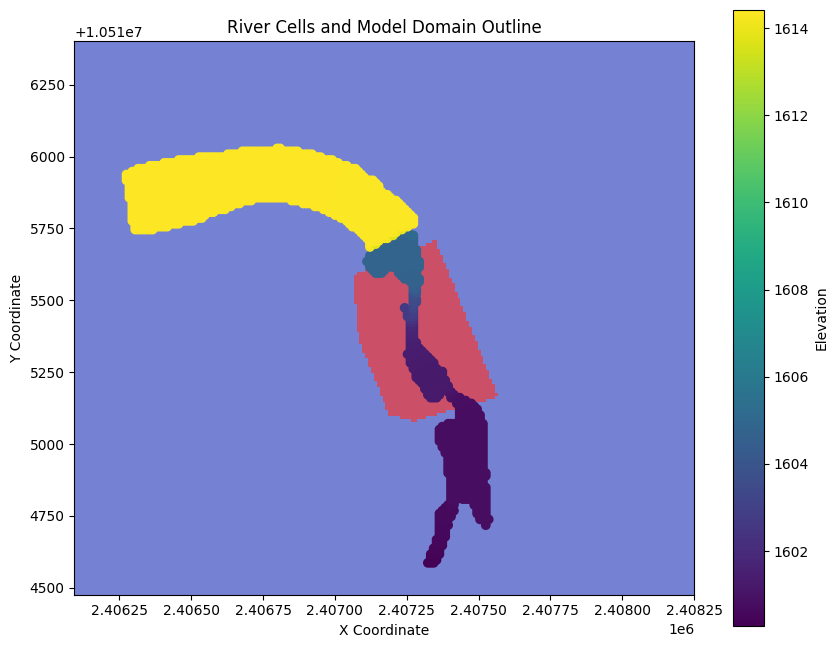

2406093.5149272773 10514475.360625861
Number of columns: 215
Number of rows: 192


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3774883372.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_transformed'] = ((df['x'] - xmin) / x_spacing).astype(int)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_23528\3774883372.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_transformed'] = ((df['y'] - ymin) / y_spacing).astype(int)


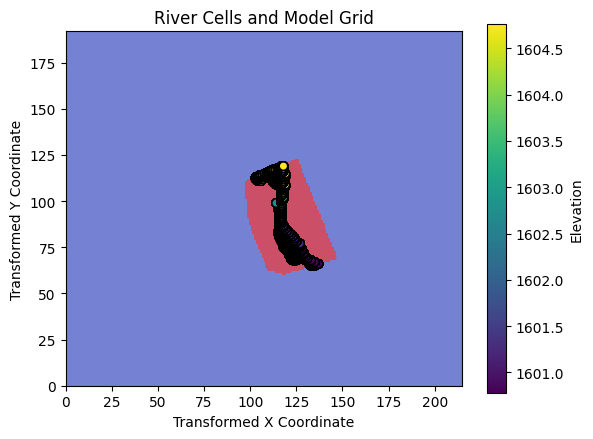

In [17]:
#----------------------Define Any River Cells ------------------------#
## Read the CSV file
grid_points_df = pd.read_csv(output_csv)

## Print the first few rows of the dataframe
print(grid_points_df.head())

## Filter out rows with NaN values in the elevation column
grid_points_df = grid_points_df.dropna(subset=['elevation'])

## Remove rows where elevation is -9999
grid_points_df = grid_points_df[grid_points_df['elevation'] != -9999]

print(grid_points_df.head())

## Plot the idomain in the background and surface water elevation on top
fig, ax = plt.subplots(figsize=(10, 8))

## Plot the idomain background
nrow, ncol = idomain.shape[1], idomain.shape[2]
idomain_plot = np.sum(idomain, axis=0)  # Sum across layers to visualize the domain
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

## Plot the river cells on top
sc = ax.scatter(grid_points_df['x'], grid_points_df['y'], c=grid_points_df['elevation'], cmap='viridis', marker='o')
plt.colorbar(sc, label='Elevation')

plt.title('River Cells and Model Domain Outline')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

print(xorigin, yorigin)

## Read the CSV file
grid_points_df = pd.read_csv(output_csv)

## Crop the CSV data to the extent of the shapefile
cropped_df = grid_points_df[(grid_points_df['x'] >= xmin) & (grid_points_df['x'] <= xmax) &
                            (grid_points_df['y'] >= ymin) & (grid_points_df['y'] <= ymax)]

## Read raster data and extract elevation values
with rasterio.open(output_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs
    raster_bounds_box = box(*src.bounds)  # Create a shapely box for raster bounds
    terrain_elevation = np.ma.masked_equal(raster_array, src.nodata)  # Mask no-data values

## Create a GeoDataFrame for raster bounds
raster_bounds_gdf = gpd.GeoDataFrame({"geometry": [raster_bounds_box]}, crs=hec_ras_crs)

## Calculate the extent of the raster
transform = raster_transform
xmin = transform.c
ymax = transform.f
xmax = xmin + (terrain_elevation.shape[1] * transform.a)
ymin = ymax + (terrain_elevation.shape[0] * transform.e)

## Determine the number of rows and columns based on the cell size
ncol = int((xmax - xmin) / cell_size_x)
nrow = int((ymax - ymin) / cell_size_y)
print(f'Number of columns: {ncol}')
print(f'Number of rows: {nrow}')


## Function to fit CSV data into the model grid
def fit_csv_to_grid(df, ncol, nrow, xmin, ymin, xmax, ymax):
    x_spacing = (xmax - xmin) / ncol
    y_spacing = (ymax - ymin) / nrow
    
    df['x_transformed'] = ((df['x'] - xmin) / x_spacing).astype(int)
    df['y_transformed'] = ((df['y'] - ymin) / y_spacing).astype(int)
    
    return df

## Fit the cropped CSV data into the model grid
cropped_df = fit_csv_to_grid(cropped_df, ncol, nrow, xmin, ymin, xmax, ymax)

## Remove any values below 0
cropped_df = cropped_df[cropped_df['elevation'] >= 0]

# # Plot to visualize
# fig, ax = plt.subplots()
# im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
#                extent=[0, ncol, 0, nrow], alpha=0.7)

# # Add transformed grid points to the plot
# scatter = ax.scatter(cropped_df['x_transformed'], cropped_df['y_transformed'], c=cropped_df['elevation'], cmap='viridis', edgecolor='k')

# plt.colorbar(scatter, ax=ax, label='Elevation')
# plt.xlabel('Transformed X Coordinate')
# plt.ylabel('Transformed Y Coordinate')
# plt.title('Transformed Grid Points and Model Grid')
# plt.show()

## Function to extract river cells
def extract_river_cells(df, idomain, nlay):
    river_cells = []
    for _, row in df.iterrows():
        x, y = int(row['x_transformed']), int(row['y_transformed'])
        river_height = row['elevation']
        if 0 <= x < idomain.shape[2] and 0 <= y < idomain.shape[1]:  # Ensure indices are within bounds
            if np.any(idomain[:, y, x] == 1):
                for k in range(nlay):
                    river_cells.append((k, y, x, river_height))
    return river_cells

## Extract river cells
river_cells = extract_river_cells(cropped_df, idomain, nlay)

## Extract coordinates and elevation from river cells
river_x = [cell[2] for cell in river_cells]
river_y = [cell[1] for cell in river_cells]
river_elevation = [cell[3] for cell in river_cells]

## Plot to visualize
fig, ax = plt.subplots()
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[0, ncol, 0, nrow], alpha=0.7)

## Add transformed river cells to the plot
scatter = ax.scatter(river_x, river_y, c=river_elevation, cmap='viridis', edgecolor='k')

plt.colorbar(scatter, ax=ax, label='Elevation')
plt.xlabel('Transformed X Coordinate')
plt.ylabel('Transformed Y Coordinate')
plt.title('River Cells and Model Grid')
plt.show()

In [18]:
#----------------------Create Constant Head Data------------------------#
# Create the CHD package
chd_data = []

# Identify boundary cells where the elevations are <= groundwater elevations
ch_left_boundary = gw_elevation_left  # Groundwater elevation list matching the left boundary cells (nlay, nrow, ncol)
ch_right_boundary = gw_elevation_right  # Groundwater elevation list matching the right boundary cells (nlay, nrow, ncol)
ch_upstream_boundary = gw_elevation_upstream  # Groundwater elevation list matching the upstream boundary cells (nlay, nrow, ncol)
ch_downstream_boundary = gw_elevation_downstream  # Groundwater elevation list matching the downstream boundary cells (nlay, nrow, ncol)

# Set to keep track of unique (nlay, nrow, ncol) coordinates
unique_chd_cells = set()
duplicate_chd_cells = set()

# Add boundary conditions for each side of the model and track duplicates

# Left Boundaries (Constant Head = ch_left_boundary)
for i, cell in enumerate(left_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_left_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Right Boundaries (Constant Head = ch_right_boundary)
for i, cell in enumerate(right_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_right_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Upstream Boundary (Constant Head = ch_upstream_boundary)
for i, cell in enumerate(upstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_upstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Downstream Boundary (Constant Head = ch_downstream_boundary)
for i, cell in enumerate(downstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_downstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# keeps river cells that are not duplicates
# doesn't override boundary cells to add river cells
for i, cell in enumerate(river_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([cell[0], cell[1], cell[2], cell[3]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol)) # Track duplicate cells (should occur in river cells)

print(f"✅ Total Unique CHD Boundary Cells: {len(unique_chd_cells)}")
print(f"❌ Total Duplicate CHD Boundary Cells: {len(duplicate_chd_cells)}")

# Convert np.float32 to standard Python float
chd_data_converted = []

for item in chd_data:
    # Check if item[3] is a list and convert each element to float
    if isinstance(item[3], list):
        converted_head_value = [float(val) for val in item[3]]
    else:
        converted_head_value = float(item[3])
    
    converted_item = [item[0], item[1], item[2], converted_head_value]
    chd_data_converted.append(converted_item)

print(f"✅ Assigned {len(chd_data_converted)} CHD boundary cells.")

# Optional: print the boundary cell counts
print(f"Left Boundary Cells: {len(left_boundary_cells)}")
print(f"Right Boundary Cells: {len(right_boundary_cells)}")
print(f"Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"Downstream Boundary Cells: {len(downstream_boundary_cells)}")
print(f"River Cells: {len(river_cells)}")

✅ Total Unique CHD Boundary Cells: 18080
❌ Total Duplicate CHD Boundary Cells: 840
✅ Assigned 18080 CHD boundary cells.
Left Boundary Cells: 2080
Right Boundary Cells: 1920
Upstream Boundary Cells: 1120
Downstream Boundary Cells: 1520
River Cells: 12280


In [19]:
# Store new variables
%store boundary_cells
%store left_boundary_cells
%store right_boundary_cells
%store upstream_boundary_cells
%store downstream_boundary_cells
%store all_boundary_cells
%store unique_boundary_cells
%store left_boundary_cells_first_layer
%store right_boundary_cells_first_layer
%store upstream_boundary_cells_first_layer
%store downstream_boundary_cells_first_layer
%store max_elevation_upstream
%store max_elevation_downstream
%store gw_elevation_left_first
%store gw_elevation_left_last
%store gw_elevation_right_first
%store gw_elevation_right_last
%store gw_elevation_upstream_first
%store gw_elevation_upstream_last
%store gw_elevation_downstream_first
%store gw_elevation_downstream_last
%store gw_elevation_left
%store gw_elevation_right
%store gw_elevation_upstream
%store gw_elevation_downstream
%store grid_points_coords
%store elevation_values
%store grid_points_df
%store output_csv
%store cropped_df
%store river_cells
%store river_x
%store river_y
%store river_elevation
%store chd_data
%store unique_chd_cells
%store duplicate_chd_cells
%store chd_data_converted

Stored 'boundary_cells' (list)
Stored 'left_boundary_cells' (list)
Stored 'right_boundary_cells' (list)
Stored 'upstream_boundary_cells' (list)
Stored 'downstream_boundary_cells' (list)
Stored 'all_boundary_cells' (list)
Stored 'unique_boundary_cells' (set)
Stored 'left_boundary_cells_first_layer' (list)
Stored 'right_boundary_cells_first_layer' (list)
Stored 'upstream_boundary_cells_first_layer' (list)
Stored 'downstream_boundary_cells_first_layer' (list)
Stored 'max_elevation_upstream' (float64)
Stored 'max_elevation_downstream' (float64)
Stored 'gw_elevation_left_first' (float64)
Stored 'gw_elevation_left_last' (float64)
Stored 'gw_elevation_right_first' (float64)
Stored 'gw_elevation_right_last' (float64)
Stored 'gw_elevation_upstream_first' (float64)
Stored 'gw_elevation_upstream_last' (float64)
Stored 'gw_elevation_downstream_first' (float64)
Stored 'gw_elevation_downstream_last' (float64)
Stored 'gw_elevation_left' (list)
Stored 'gw_elevation_right' (list)
Stored 'gw_elevation_u